In [1]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import operator
import datetime as dt
# import matplotlib
# matplotlib.use("Agg")
from datetime import datetime, timedelta,date
import matplotlib.pyplot as plt
# import matplotlib.pylab as plt
%matplotlib inline

/root/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df_train = pd.read_csv("./train.csv", low_memory=False)
df_test = pd.read_csv("./test.csv", low_memory=False)
df_store = pd.read_csv("./store.csv", low_memory=False)
seed = 123

In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
store = pd.read_csv('./store.csv')
#1、去除销量中的极值,由于无法估计极值对结果的影响，所以拟合模型的时候可以进行两次，去除极值和未去除极值
#再试一下标准差标准误差
# def rm_outliers(df): 
#     q1 = np.percentile(df['Sales'], 25, axis=0)
#     q3 = np.percentile(df['Sales'], 75, axis=0)
#     k = 2.5
#     iqr = q3 - q1
#     df = df[df['Sales'] > q1 - k*iqr]
#     df = df[df['Sales'] < q3 + k*iqr]
#     return df

# def rm_outliers_std(df): 
#     std = df['Sales'].std()
#     mean = df['Sales'].mean()
#     k = 3
#     df = df[df['Sales'] >  mean - k*std]
#     df = df[df['Sales'] < mean + k*std]
#     return df

#2、对时间的拆分
def data_processing(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['DayOfYear'] = df['Date'].apply(lambda x: x.dayofyear)
    df['WeekOfYear'] = df['Date'].apply(lambda x: x.week)
    df['Month'] = df['Date'].apply(lambda x: x.month)
    df['DayOfMonth'] = df['Date'].apply(lambda x: x.day)
    df['Year'] = df['Date'].apply(lambda x: x.year)
    return df

#4、为每个日期添加过去一个季度，过去半年，过去一年，过去两年的这家店的平均日销售量
def store_sales_each_day(sale):
    
    def add_mean(store,sale,current_date,past_time):
        past_date = current_date - timedelta(days=past_time)
        mean_sale = sale[(sale['Date'] < current_date) & (sale['Date'] > past_date) & (sale['Store'] == store)]['Sales'].mean()
        return mean_sale
    
    sale['past_quater_mean_sale'] = sale.apply(lambda row: add_mean(row['Store'], sale, row['Date'], 90), axis=1)
    sale['past_year_mean_sale'] = sale.apply(lambda row: add_mean(row['Store'], sale, row['Date'], 183), axis=1)
    
    return sale

#测试集调整
def store_sales_each_day_for_test(sale,test):
    
    def add_mean(store,sale,current_date,past_time):
        past_date = current_date - timedelta(days=past_time)
        mean_sale = sale[(sale['Date'] < current_date) & (sale['Date'] > past_date) & (sale['Store'] == store)]['Sales'].mean()
        return mean_sale
    
    test['past_quater_mean_sale'] = test.apply(lambda row: add_mean(row['Store'], sale, row['Date'], 90), axis=1)
    test['past_year_mean_sale'] = test.apply(lambda row: add_mean(row['Store'], sale, row['Date'], 183), axis=1)

    return test

#3、为每家店添加销售量客流量相关的均值,执行顺序在对时间进行拆分后
def add_mean_for_store(sales,store_df=store) :
    mean_sales_promo = []
    mean_sales_no_promo = []
    mean_sales = []
    mean_sales_2013 = []
    mean_sales_2014 = []
    mean_sales_2015 = []
    mean_store_sales_1month = []
    mean_store_sales_2months = []
    mean_store_sales_3months = []
    mean_store_sales_6months = []
    
    
    mean_customers_promo = []
    mean_customers_no_promo = []
    mean_customers = []
    mean_customers_2013 = []
    mean_customers_2014 = []
    mean_customers_2015 = []
    mean_customers_1month = [] 
    mean_customers_2months = [] 
    mean_customers_3months = []
    mean_customers_6months = []
    
    
    for store in store_df['Store']:
        sale = sales[sales['Store']==store]
        
        # mean of sales
        mean_sales.append(sale['Sales'].mean())
        mean_sales_promo.append(sale[sale['Promo'] == 1]['Sales'].mean())
        mean_sales_no_promo.append(sale[sale['Promo'] == 0]['Sales'].mean())
        mean_sales_2013.append(sale[sale['Year'] == 2013]['Sales'].mean())
        mean_sales_2014.append(sale[sale['Year'] == 2014]['Sales'].mean())
        mean_sales_2015.append(sale[sale['Year'] == 2015]['Sales'].mean())
        mean_store_sales_1month.append(sale[(sale['Month'] == 7) & (sale['Year'] == 2015)]['Sales'].mean())                   
        mean_store_sales_2months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 6) & (sale['Year'] == 2015)]['Sales'].mean())
        mean_store_sales_3months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 5) & (sale['Year'] == 2015)]['Sales'].mean())        
        mean_store_sales_6months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 2) & (sale['Year'] == 2015)]['Sales'].mean())
        
        # mean of customers
        mean_customers.append(sale['Customers'].mean())
        mean_customers_promo.append(sale[sale['Promo'] == 1]['Customers'].mean())
        mean_customers_no_promo.append(sale[sale['Promo'] == 0]['Customers'].mean())
        mean_customers_2013.append(sale[sale['Year'] == 2013]['Customers'].mean())
        mean_customers_2014.append(sale[sale['Year'] == 2014]['Customers'].mean())
        mean_customers_2015.append(sale[sale['Year'] == 2015]['Customers'].mean())
        mean_customers_1month.append(sale[(sale['Month'] == 7) & (sale['Year'] == 2015)]['Customers'].mean())                   
        mean_customers_2months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 6) & (sale['Year'] == 2015)]['Customers'].mean())
        mean_customers_3months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 5) & (sale['Year'] == 2015)]['Customers'].mean())        
        mean_customers_6months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 2) & (sale['Year'] == 2015)]['Customers'].mean())
        
    store_df['mean_sales'] = mean_sales
    store_df['mean_sales_promo'] = mean_sales_promo
    store_df['mean_sales_no_promo'] = mean_sales_no_promo
    store_df['mean_sales_2013'] = mean_sales_2013
    store_df['mean_sales_2014'] = mean_sales_2014
    store_df['mean_sales_2015'] = mean_sales_2015
    store_df['mean_store_sales_1month'] = mean_store_sales_1month
    store_df['mean_store_sales_2months'] = mean_store_sales_2months
    store_df['mean_store_sales_3months'] = mean_store_sales_3months
    store_df['mean_store_sales_6months'] = mean_store_sales_6months
    
    store_df['mean_customers'] = mean_customers
    store_df['mean_customers_promo'] = mean_customers_promo
    store_df['mean_customers_no_promo'] = mean_customers_no_promo
    store_df['mean_customers_2013'] = mean_customers_2013
    store_df['mean_customers_2014'] = mean_customers_2014
    store_df['mean_customers_2015'] = mean_customers_2015
    store_df['mean_customers_1month'] = mean_customers_1month
    store_df['mean_customers_2months'] = mean_customers_2months
    store_df['mean_customers_3months'] = mean_customers_3months
    store_df['mean_customers_6months'] = mean_customers_6months
    
    return store_df

def drop_stores(data_test, data):
	stores = data_test['Store'].unique()         
	return data[data_test['Store'].isin(stores)]

#合并销售和商店 
def merge_sale(sale_data, store_data):
    train = sale_data.join(store_data, on='Store', rsuffix='_')
    train = train.drop('Store_',axis=1)
    return train

#添加其他特征
def extra_features(data):
    data['CompetitionOpen'] = 12 * (data['Year'] - data['CompetitionOpenSinceYear']) + (data['Month'] - data['CompetitionOpenSinceMonth'])
    data['PromoOpen'] = 12 * (data['Year'] - data['Promo2SinceYear'])+ (data['WeekOfYear'] - data['Promo2SinceWeek']) / 4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0
    data = data.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear'], axis=1) #删除特征
    
    mappings = {'0': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4,'Jan,Apr,Jul,Oct':1,'Feb,May,Aug,Nov':2,'Mar,Jun,Sept,Dec':3}  
    data['StoreType'].replace(mappings, inplace=True)  
    data['Assortment'].replace(mappings, inplace=True)  
    data['StateHoliday'].replace(mappings, inplace=True)
    data['PromoInterval'].replace(mappings, inplace=True)
#     data = data.drop(['Date'],axis= 1)
    return data

#去除极大极小值
# print('Moving outliers')
# train = rm_outliers(train)

#转换年月日
print('Convert Time')
train = data_processing(train)
test = data_processing(test)

#给商店计算平均销售量
store = add_mean_for_store(train)
store = drop_stores(test, store)

print('add additional past_quater_mean_sale and past_year_mean_sale')
#添加额外特征'past_quater_mean_sale'和'past_year_mean_sale'，这段代码运行时间可能会过长
# train = store_sales_each_day(train)
# test = store_sales_each_day_for_test(train,test)

print('Merging')
#合并
train = merge_sale(train, store)
test = merge_sale(test, store)
# train.to_csv('train_withextra.csv',index=False)
# test.to_csv('test_withextra.csv',index=False)

#额外的特征
train = extra_features(train)
test = extra_features(test)

holidayofyear = sorted(train[train['StateHoliday'].isin([1,2,3,4])]['DayOfYear'].unique())
def day2holiday(df,holidayofyear):
    for holiday in holidayofyear:
        df['DaysToHoliday' + str(holiday)] = holiday - df['DayOfYear']
    return df

#计算距离节日的日子数
train = day2holiday(train,holidayofyear)
test =  day2holiday(test,holidayofyear)
#参考Joe Kington进行异常值检验
# https://stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data/22357811#22357811
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

# df = train
for i in train['Store'].unique():
    train.loc[(train['Store'] == i) & (train['Open'] == 1), 'Outline'] =mad_based_outlier(train.loc[(train['Store'] == i) & (train['Open'] == 1)]['Sales'],2.8)
print('Final output')
#生成最终输入



/root/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Convert Time


/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


add additional past_quater_mean_sale and past_year_mean_sale
Merging
Final output


In [4]:
# train = pd.read_csv('./train_to_clear.csv')
# test = pd.read_csv('test_to_clear.csv')
a1 = train.columns
a2 = ['Date','Sales','Customers','Outlier']
a1 = [f for f in a1 if f not in a2]


In [8]:
# 参考编写评估函数
# https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

def split_train(train,days = 42):  #分割数据集
    end_date = date(2015,7,31)
    begin_date = date(2013,1,1)
    split_data = str(end_date-timedelta(days))
    test  = train[train['Date']>split_data]
    train1 = train[train['Date']<split_data]
    return train1,test

In [9]:
df = train
df = df.loc[(df['Outlier'] == False) & (df['Open'] == 1)]

print(len(train),len(df))
train = df

1017209 826902


In [10]:
seed = 1301
depth = 9
eta = 0.1
ntrees = 10000
mcw = 0.8
tsize = 0.1
X_train, X_test, y_train, y_test = train_test_split(train[a1],train['Sales'],test_size=tsize, random_state=seed)

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
    
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

param = {'max_depth': 9,
     'eta': 0.1,
     'subsample': 1,
     'alpha': 2, 
     'gamma': 2,
     'colsample_bytree': 0.7,
     'silent': 1,
     'objective': 'reg:linear',
     'seed': 1301,
     'lambda': 2,
     'tree_method': 'gpu_hist'}

print(param)
bst = xgb.train(param, dtrain, ntrees, watchlist, feval=rmspe_xg, verbose_eval=100, early_stopping_rounds=100)

{'max_depth': 9, 'eta': 0.1, 'subsample': 1, 'alpha': 2, 'gamma': 2, 'colsample_bytree': 0.7, 'silent': 1, 'objective': 'reg:linear', 'seed': 1301, 'lambda': 2, 'tree_method': 'gpu_hist'}
[0]	train-rmse:7.43177	eval-rmse:7.43292	train-rmspe:0.999517	eval-rmspe:0.999517
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[100]	train-rmse:0.157469	eval-rmse:0.160425	train-rmspe:0.169748	eval-rmspe:0.172218
[200]	train-rmse:0.119858	eval-rmse:0.124879	train-rmspe:0.126842	eval-rmspe:0.130939
[300]	train-rmse:0.105952	eval-rmse:0.112665	train-rmspe:0.111925	eval-rmspe:0.117136
[400]	train-rmse:0.09852	eval-rmse:0.106705	train-rmspe:0.104559	eval-rmspe:0.110525
[500]	train-rmse:0.093932	eval-rmse:0.103051	train-rmspe:0.099973	eval-rmspe:0.106616
[600]	train-rmse:0.090967	eval-rmse:0.100966	train-rmspe:0.096958	eval-rmspe:0.104338
[700]	train-rmse:0.08851	eval-rmse:0.099421	train-rmspe:0.094461	eval

In [11]:
# {'max_depth': 9, 'eta': 0.1, 'subsample': 1, 'alpha': 2, 'gamma': 2, 'colsample_bytree': 0.8, 'silent': 1, 'objective': 'reg:linear', 'seed': 1301, 'lambda': 2, 'tree_method': 'gpu_hist'}
# {'max_depth': 9, 'eta': 0.1, 'subsample': 1, 'alpha': 2, 'gamma': 2, 'colsample_bytree': 0.7, 'silent': 1, 'objective': 'reg:linear', 'seed': 1301, 'lambda': 2, 'tree_method': 'gpu_hist'}
# [4765]	train-rmse:0.065362	eval-rmse:0.09156	train-rmspe:0.067719	eval-rmspe:0.093572
print("predictions data set")
myid = 'Id'
goal = 'Sales'
teset = test[test['Open']==1]
test_probs = bst.predict(xgb.DMatrix(test[a1]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({myid: test[myid], goal: np.exp(test_probs) - 1})
li = []
sub = submission
for i in np.arange(1,len(df_test)+1):
    if len(sub[sub['Id']==i]['Sales'])>0:
        li.append(int(sub[sub['Id']==i]['Sales']))
    else:
        li.append(0)
sub = pd.DataFrame({myid: np.arange(1,len(df_test)+1), goal: li})
sub.to_csv("./result/dat-xgb_d0010depth%s_eta%s_ntree%s_mcw%s_tsize%s.csv" % (str(depth),str(eta),str(ntrees),str(mcw),str(tsize)) , index=False)  

predictions data set


/root/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/root/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


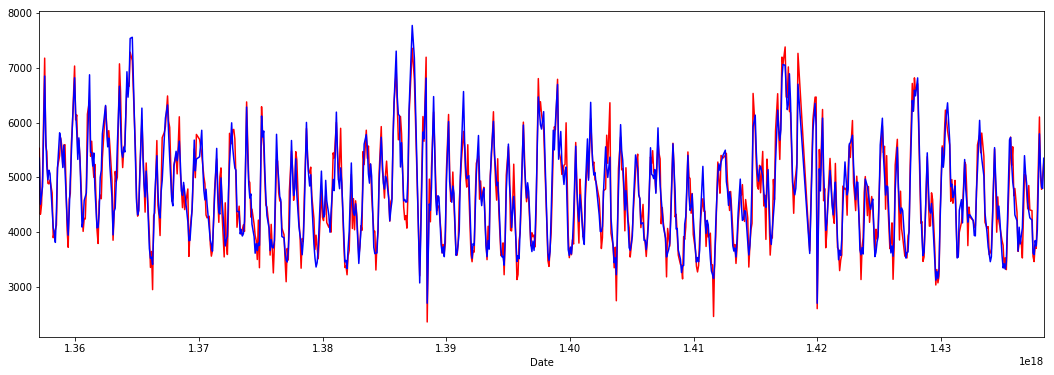

In [12]:
train_pro = bst.predict(xgb.DMatrix(train[train['Store']==1][a1]))
indices = train_pro < 0
train_pro[indices] = 0
pro_data = train[train['Store']==1][['Date','Sales']]
pro_data['train_pro'] = np.exp(train_pro) - 1
import seaborn as sns

plt.figure(1,figsize=(18,6))
pro_data.Date = pd.to_datetime(pro_data.Date,format='%Y-%m-%d')
sns.tsplot(pro_data.Sales,pro_data.Date,color='r')
sns.tsplot(pro_data.train_pro,pro_data.Date,color='b')

In [13]:
#部分商店预测对比图
test_pro = bst.predict(xgb.DMatrix(test[test['Store']==1][a1]))
indices = test_pro < 0
test_pro[indices] = 0
pro_test = test[test['Store']==1]['Date']
pro_test['test_pro'] = np.exp(test_pro)-1
pro_data = train[train['Store']==1][['Date','Sales']]
pro_data['train_pro'] = np.exp(train_pro) - 1
import seaborn as sns

/root/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:914: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value
/root/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


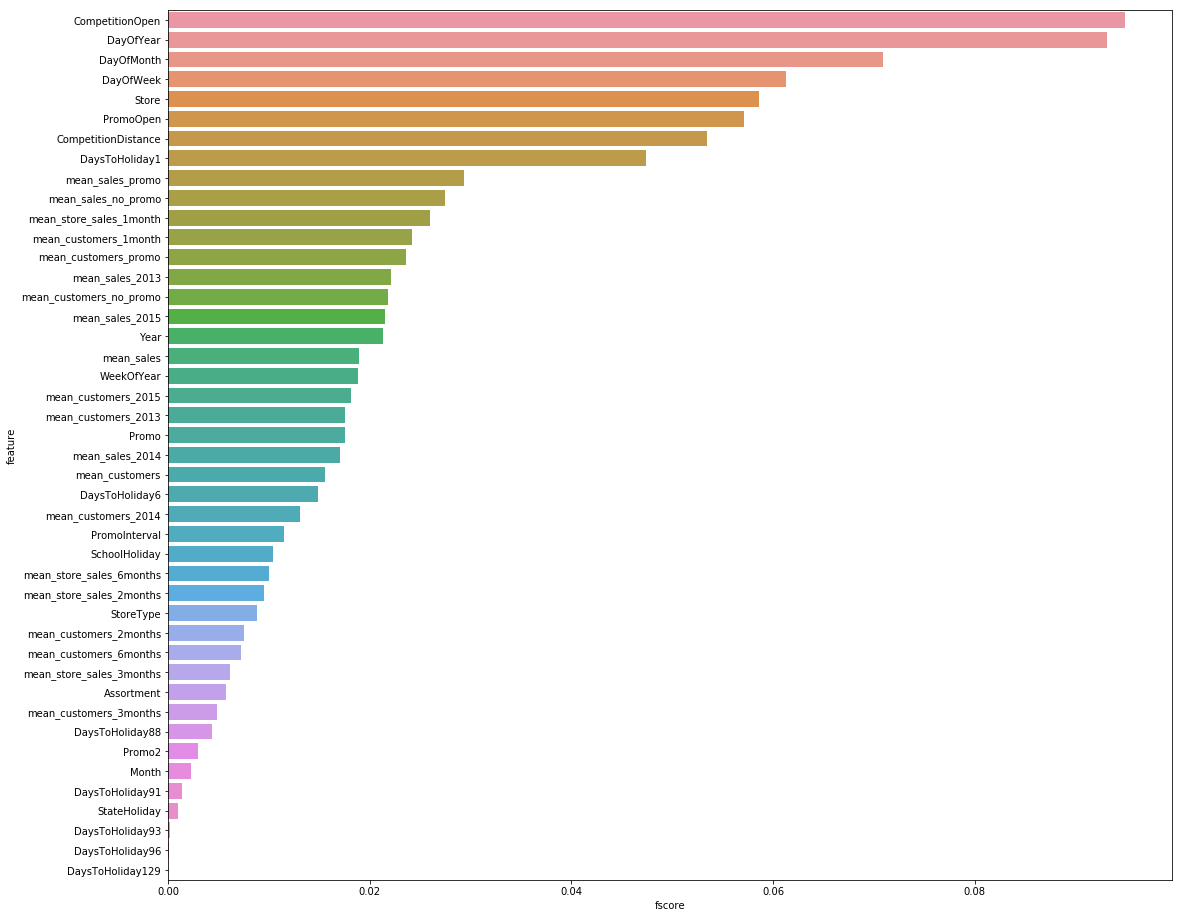

In [14]:
import matplotlib.pylab as plt
%matplotlib inline
importance = bst.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

dff = pd.DataFrame(importance, columns=['feature', 'fscore'])
dff['fscore'] = dff['fscore'] / dff['fscore'].sum()

plt.figure(1,figsize=(18,16))
sfg = sns.barplot(x='fscore',y='feature',data=dff.sort_values(by=['fscore'],ascending=False),ci=1)
sf = sfg.get_figure()
sf.savefig("./result/output.png")